## Spectral graph analysis
* [Excellent Class notes of course by Professor Daniel Spielman](http://www.cs.yale.edu/homes/spielman/561/2012/)

Spectral Graph analysis provides one of the most interesting non-linear and non-parametric methods for data analysis. The only structure we need to perform this kind of analysis is a rule that tells us which datapoints are "similar" and which are not. This very local information is used to create a graph and the Laplace transform is used to provide a global characterization of the graph.

Through this analysis we gain useful insights into the structure of our dataset. In particular, we will show how to use it to partition the graph into clusters and to embed the graph in a low dimensional euclidean space.

#### From data points to a graph

Let us define a graph $G=(V,E)$ where the vertices (nodes) correspond to data points, and edges connect "similar" points. For example, we might define a function that measures the distance between data points. We can define the edges in various ways. One way put an edge between any two vertices if the distance between the corresponding points is smaller than some threshold. Another way is to connect each point to the $k$ closest points.(Weighted edges are also allowed, but for the analysis given here, we assume all edges have equal weight).

#### The Laplace matrix captures the dynamics of heat dispersion.

Imagine the graph $G=(V,E)$ as representing a physical object. Suppose the vertices are metal balls and the edges are metal rods connecting the balls.
Suppose that at time zero each ball (vertex) $v$ is set at a different temperature. At each time step heat flows from the warmer balls to the cooler balls. After a long enough time, the temperature of all of the balls will be the same. What we want to analyze is the way in which this limit would be reached. 

In order to define the Laplace matrix, let us assume that the vertices are indexed by integers $1,\ldots,n$. Denote the temperature of vertex $i$ at time $T$ by $T_i^t$.
Denote set of neighbors of vertes $i$ by $N(i)$.

Heat dispersion is a process that minimizes the square of the difference in temperature between neighboring balls. For node $i$ this is equivalent to minimizing the sum
$$
Pot^t_i = \sum_{j \in N(i)} (T^t_j - T^t_i)^2
$$

The time evolution of the temperature at node $i$ is proportional to the gradient of $Pot_i^t$ with respect to $t$
$$
\Delta_i^t \doteq T_i^{t+1}-T_i^{t} = C \sum_{j \in N(i)} (T^t_j - T^t_i) = C \left(\left(\sum_{j \in N(i)} T^t_j\right) - \left|N(i)\right| T^t_i \right)
$$
Where $C$ is a conductance constant which is set small enough that this discrete time process will be close to the physical process that occurs in continuous time. $|N(i)|$ is the size of the set of neighbors $N(i)$

Denote by $T^t$ the column vector $(T_1^t,T_2^t,\ldots,T_n^t)^{\top}$ and by $\Delta^t$ the column vector
$(\Delta_1^t,\Delta_2^t,\ldots,\Delta_n^t)^{\top}$. Clearly $\Delta^t$ is a linear function of $T^t$. We can express this relation using matrix notation as follows.

Define the Adjacency matrix as follows:
$$A_{i,j} = \cases{1 & \text{there is an edge between $i$ and $j$} \\
                   0 & \text{otherwise} }$$
Define the Degree matrix to be a diagonal matrix where the element $D_{i,i}$ is the degree of vertex $i$, which is to say, the number of vertices for which $i$ is one of the end points. (self loops are not allowed).

Using the matrices $A$ and $D$ we can define the Laplace matrix to be 
$$L= D-A$$
and we can then express the relationship between $\Delta^t$ and $T^t$ as $\Delta^t = -C L T^t$.

As L is a symmetric matrix it can be expressed as an eigen-decomposition:

$$L = O \Lambda O^{\top}$$ 
where $O$ is an orthonormal matrix whose coumns are the eigenvectors of $L$, which we denote by $V_0,\ldots,V_n$, and $\Lambda$ is a diagonal matrix whose diagonal values are the corresponding eigen-values $\lambda_1,\ldots,\lambda_n$

A few observations are in order:
* The vector $\frac{1}{\sqrt{n}}(1,1,\ldots,1)^{\top}$ is an eigen-vector whose eigen value is zero. This corresponds to the observation that if all of the balls are at the same temperature than the temperatures of all balls will remain the same, i.e. $\Delta^t = 0$.
We call this eigen-vector $V^0$. As $V^0$ is independent of properties of the graph (other than being connected) it provides us with no information.
* We decompose the initial temperature vector $T^0$ using the eigenvectors:
$T^0 = \sum_{i=1}^n a_i V_i$, then the time evolution of the temperature can be decomposed as follows:
$$
T^1=T^0+\Delta^0 = T^0-C L T^0 = \sum_i a_i (1-C\lambda_i) V_i
$$
we can repeat this relationship for time steps $t=1,2,3,\ldots,t$ and find that
$$
T^t = \sum_i a_i (1-C\lambda_i)^t V_i
$$
We claim without proof that the eigenvalues are non-negative. We Assume that $C$ is small enough that $C\lambda <1$. As as result we get that the coefficient of $V_0$ remains unchanged throughout time. As for the coefficients of any other eigen-vector $V_i$ it progresses as $a_i,a_i(1-C\lambda_i),\ldots,a_i(1-C\lambda_i)^t,\ldots$, and as $\lambda_i>0$, $(1-C\lambda_i)<1$ and raising this number to the power $t$ decreases exponentially to zero. In other words, the coefficients of all eigenvectors other than $V_0$ decay to zero over time. The **rate** of the decay is determined by the eigen-value. If the eigen-value is close to zero, then the decay is slow. We are thus interested in the eigen-vectors whose eigen values are **close** to zero, but not equal to zero - which corresponds to the uniform eigen-vector $V_0$.
* Compare this analysis to PCA, there as here, we use an eigen-decomposition. However, in PCA we are most interested in the eigen-vectors with the largest eigen-values, while here we are interested in the eigen-vectors whose eigen-values are second-smallest, third smallest etc.



In [1]:
%pylab inline
from IPython.display import Image, display

Populating the interactive namespace from numpy and matplotlib


### Read a pydot  graph

In [2]:
import pydot

In [3]:
filenames=['circle', 'line', 'star', 'torus', 'twoD', 'twoblobs']
filename='twoD'
def read_graph(filename):
    dot=open('dot/'+filename+'.dot','r').readlines()
    dot=''.join(dot)

    G,=pydot.dot_parser.parse_dot_data(dot)
    gif_name='gifs/'+filename+'.gif'
    G.write_gif(gif_name)
    return G,gif_name

### Compute graph matrices
* A: Adjacency matrix
* D: Degree Matrix

In [4]:
from numpy.linalg import eigh
from numpy import matrix

def calc_laplacian(G):
    node_n=len(G.get_nodes())
    A=matrix(np.zeros([node_n,node_n])) # adjacency matrix
    for edge in G.get_edge_list():
        _i=int(edge.get_source())
        _j=int(edge.get_destination())
        A[_i,_j]=1
        A[_j,_i]=1

    D=matrix(np.zeros([node_n,node_n])) # degree matrix 
    for i in range(node_n):
        D[i,i]=sum(A[i,:])
    L=D-A  # the laplacian

    w,v=eigh(L) # perform eigen-decomposition of a symmetric (Hermitian) matrix
    return w,v,A,D

### Color graphs by value
This code is used both to visualize the eigenvectors and to visualize the time evolution of the temperature profile

In [5]:
_range=[0.,100.]
_offset=_range[0]
_scale=_range[1]-_range[0]

def vec2color(vec,_min,_max,ScaleEachVec=False):
    if ScaleEachVec:
        _max=np.max(vec)
        _min=np.min(vec)

    return['grey'+str(int(_offset+_scale*(x-_min)/(_max-_min))) for x in vec]

def color_graph(G,v,filename,gifs_n=10,forward=True,ScaleEachVec=False):
    node_n=shape(v)[1]
    _max=np.max(v.flatten())
    _min=np.min(v.flatten())

    #print("shape of v=",shape(v))
    node_list=G.get_node_list() #get node list before adding counter
    Counter=pydot.Node("Counter",label=0,fontsize=30)
    G.add_node(Counter)
    for j in range(min(gifs_n,node_n)):
        if forward:
            colors=vec2color(v[:,j],_min,_max,ScaleEachVec=ScaleEachVec)
        else:
            colors=vec2color(v[:,node_n-j-1],_min,_max,ScaleEachVec=ScaleEachVec)
        
        #print(j,colors)
        Counter.set_label(j)
        for node in G.get_node_list():
            node_name=node.get_name()
            try:
                i=int(node_name)
                node.set_color(colors[i])
            except:
                #print('not int=',node_name)
                continue
        G.write_gif("gifs/%s.%d.gif"%(filename,j))

In [6]:
def print_eig(w,v):
    for i in range(node_n):
        print(str(i),'eigval:%5.2f'%w[i], end=' ')
        print('eigvec:',', '.join(['%5.1f'%x for x in v[:,i]]))

In [7]:
from glob import glob
import imageio
from IPython.display import Image
def make_gif_movie(gifs_n,filename,duration=0.1):
    #print('gifs_n=',gifs_n)
    images=[]
    for i in range(gifs_n):
        file='gifs/%s.%1d.gif'%(filename,i)
        images.append(imageio.imread(file))
        #print('read ',file)
    movie_file='gifs/'+filename+'.movie.gif'
    imageio.mimsave(movie_file, images,duration=duration)
    return movie_file

def process_graph(filename):
    G,gif_name=read_graph(filename)
    w,v,A,D=calc_laplacian(G)
    color_graph(G,v,filename,ScaleEachVec=False,gifs_n=v.shape[1]) # plot the eigen-vectors as colors on a graph
    movie_file = make_gif_movie(v.shape[1],filename,duration=1)
    Image(filename = movie_file, width=100, height=500)
    return w,v,A,D,G,movie_file

In [8]:
def graph_time_evolution(init,filename,steps=4):
    """Create a movie of the evolution of values on graph vertices"""
    coeffs=np.array(np.dot(init,v)).reshape((-1,))
    recon=np.dot(coeffs,v.transpose())

    V=[]
    figure(figsize=(10,7))
    for i in range(0,steps):
        t=i
        C=coeffs*(exp(-t*w).transpose())
        X=np.dot(C,v.transpose()).transpose()
        plot(X,label='t='+str(i))
        #print(X.shape,C.shape)
        V.append(X)
    legend()
    title(filename+':  time evolution of temperature profile')
    W=np.array(V[-1::-1]).squeeze().transpose()
    
    #print('W.shape=',W.shape,"len(V)=",len(V))
    #print('W=',W)
    color_graph(G,W,filename,gifs_n = steps,forward=False,ScaleEachVec=True)
    #print('steps=',steps)
    movie_file=make_gif_movie(steps,filename,duration=0.5)
    
    return W,movie_file


### The two-blob graph
also called the dumbbell graph, consists of two cliques (fully connected sub-graphs) connected by a single edge.
#### EigenVectors and EigenValues

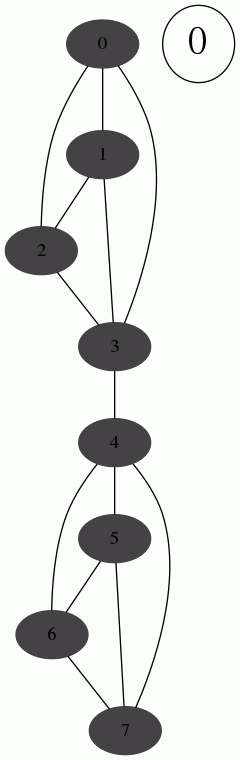

In [9]:
filename='twoblobs'
w,v,A,D,G,movie_file=process_graph(filename)
Image(filename = movie_file, width=100, height=500)
#!open gifs/twoblobs.*.gif

This graph is clearly separable into two clusters, corresponding to the two cliques. The second eigenvector identifies these clusters nicely!
In fact, there is an approach to clustering based on this analysis that is called [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering), it has also gained popularity in computer vision as [Spectral Clustering for Image Segmentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_segmentation_toy.html)

![pic](images/EigenVectors/twoBlob.jpg)

#### Time Evolution

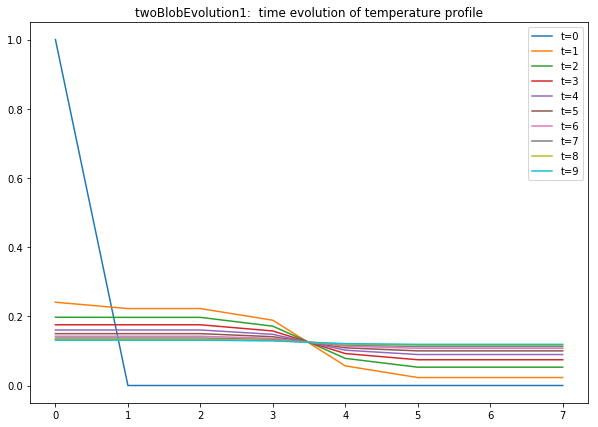

In [10]:
init=np.zeros(v.shape[0])
#print('init.shape=',init.shape)
init[0]=1
W,movie_file=graph_time_evolution(init,'twoBlobEvolution1',steps=10)

#### note: colors are scaled for each iterations
Therefor, the actual values might be changing even though the colors are not.

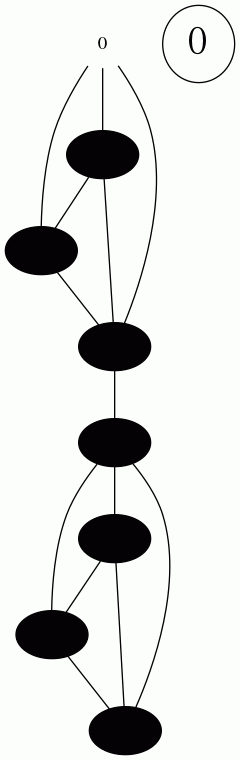

In [11]:
Image(filename = movie_file, width=100, height=500)

### The line graph
Is a simple graph where each node has two neighbors other then the two endpoints that have just one neighbor.

#### EigenVectors and EigenValues

In [12]:
w,v,A,D,G,movie_file=process_graph('line')
#Image(filename = movie_file, width=100, height=500)

eigenvals= [-1.90991132e-16  1.71102773e-02  6.81483474e-02  1.52240935e-01]


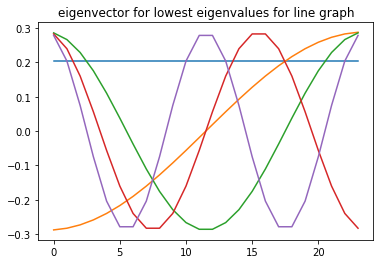

In [13]:
print('eigenvals=',w[:4])
plot(v[:,:5]);
title('eigenvector for lowest eigenvalues for line graph');

The first eigen vector is a constant that has an eigen-value of zero. The second one is the  most useful for us: it gives us a parameterization from -0.3 to +0.3 along the line.

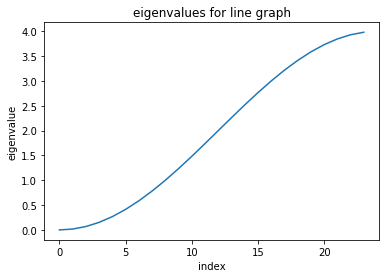

In [14]:
plot(w)
xlabel('index')
ylabel('eigenvalue')
title('eigenvalues for line graph');

#### time evolution

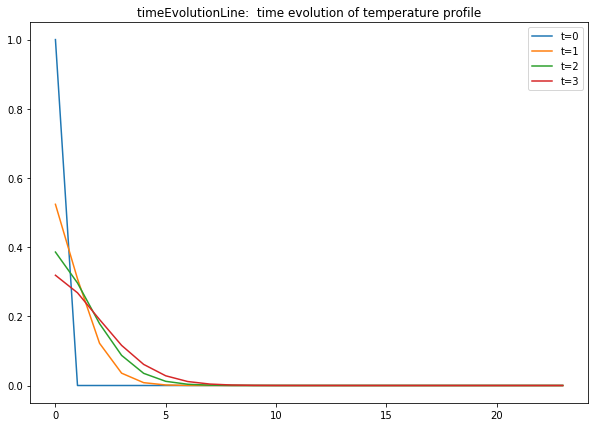

In [15]:
# compute the projection of a start vector which is a delta function
init=np.zeros(v.shape[0])
init[0]=1; init[-1]=0
w, fig = graph_time_evolution(init, "timeEvolutionLine")

### A 2D graph

#### Eigenvectors

In [16]:
w,v,A,D,G, movie_file=process_graph('twoD')
print(w[:6])
#Image(filename = movie_file, width=100, height=500)

[-6.47714478e-16  5.85786438e-01  5.85786438e-01  1.17157288e+00
  2.00000000e+00  2.00000000e+00]


Consider the three eigen-vectors with the smallest eigenvalues.

* Eigenvector 0: The uniform vector is always an eigenvector with eigen-value 0.
* Eigenvectors 1 and 2: these are, for us, the most meaningful eigenvectors. They have the smallest eigen-value that is not zero (0.59) which means that they are the slowest to decay. As we see, these eigenvectors capture the 2D structure of the graph. Specifically, eigen-vector 1 assigns to each vertex a value proportional to the distance from vertex 15. While eigen-vector 2 assigns it the distance from vertex 3. It is not hard to see that these two values form a 2D coordinate system for the 2D graph.
![pic](images/EigenVectors/twoD.1.jpg)

Higher order eigen-vectors have larger eigen-values and corresponds to patterns that vary more rapidly across the graph.

![pic](images/EigenVectors/twoD.2.jpg)

#### Time Evolution

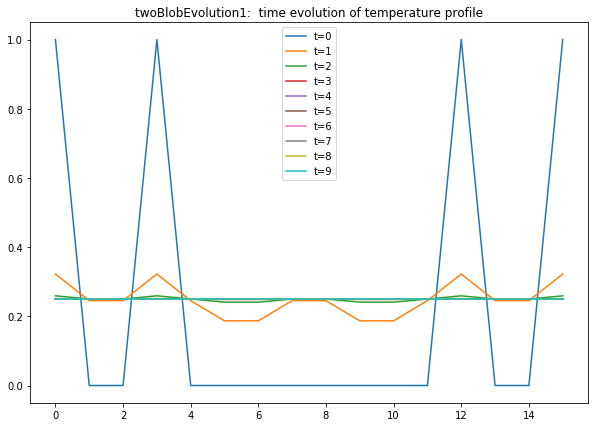

In [17]:
init=np.zeros(v.shape[0])
init[0]=1
init[12]=1
init[3]=1
init[15]=1
W,movie_file=graph_time_evolution(init,'twoBlobEvolution1',steps=10)

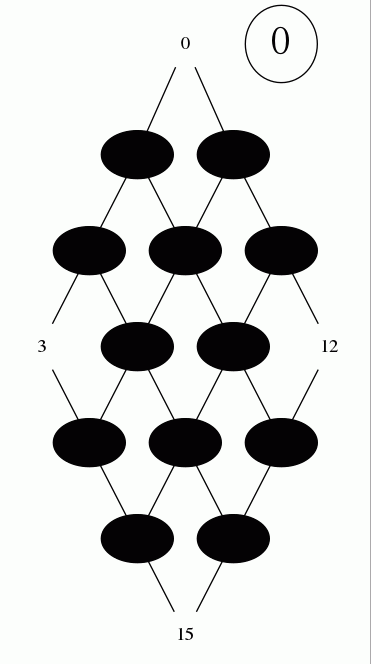

In [18]:
Image(filename = movie_file,width=200, height=300)

### random walk
The heat dispersion process is intimately related to another physical process: the random walk.

The **Lazy random walk** process can be described as follows: A pebble is placed on one of the nodes of the graph, the the following process ensues. First, with probabities 1/2,1/2 a choice is made whether to *stay put* or to *move* to one of the neighboring nodes. If the choice is to move, the specific neighbor is chosen at random with equal probability for all of the neighbors.

Now imagine that there is a huge number of pebbles and that they are all performing random walk at the same time. We can think about the fraction of pebbles on each node as a probability distribution and ask how this distribution evolved over time.

Denote by $p_i^t$ the fraction of the pebbles that is on node $i$ at time $t$. Then the update rule for the probabilities is:
$$
p_i^{t+1} = \frac{1}{2}\left( p_i^t +  \sum_{j \in N(i)} \frac{p_j^t}{d_j} \right)
$$

We can re-write this in matrix form:
$$
p^{t+1} = \frac{1}{2} \left(I + A D^{-1} \right) p^t
$$

In [ ]:
filename='star'
w,v,A,D,G,movie_file=process_graph(filename)
Image(filename = movie_file,width=500, height=300)

In [ ]:
node_n = shape(A)[0]
DI = matrix(np.zeros([node_n,node_n])) # Inverse of degree matrix 
for i in range(node_n):
    DI[i,i]=1./D[i,i]
W=0.5*(eye(node_n)+A*DI)

In [ ]:
ww,vv=eig(W)
print_eig(ww,vv)